In [1]:
import os
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from emnist import list_datasets, extract_training_samples, extract_test_samples

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import reciprocal, uniform, randint

def flatten(data, dim_img = (28, 28)):
    return data.reshape(len(data), dim_img[0] * dim_img[1])
    
print(list_datasets())

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']


In [2]:
tipus = "balanced"

X_full_train, y_full_train = extract_training_samples(tipus)
X_test, y_test = extract_test_samples(tipus)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size = 0.1, random_state = 123)

# X_train_red, y_train_red = flatten(X_train[:10000]), y_train[:10000]

# SVM C

1. gridsearch: param_dist = {"svc__gamma" : uniform(1e-6, 0.01), "svc__C" : uniform(0.1, 15)} # n_iter = 30, n_mostra = 3000
2. gridsearch: param_dist = {"svc__gamma" : reciprocal(1e-6, 1e-3), "svc__C" : uniform(1, 15)} # n_iter = 30, n_mostra = 4000
3. gridsearch: param_dist = {"svc__gamma" : reciprocal(1e-4, 1e-3), "svc__C" : uniform(2, 12)} # n_iter = 20, n_mostra = 5000
4. gridsearch: param_dist = {"svc__gamma" : reciprocal(0.00075, 0.00125), "svc__C" : uniform(3, 9)} # n_iter = 15, n_mostra = 5000

In [78]:
from sklearn.svm import SVC

X_train_red, y_train_red = flatten(X_train[12000:17000]), y_train[12000:17000] # agafem mostres diferents per cada tanda

param_dist = {"svc__gamma" : reciprocal(0.00075, 0.003), "svc__C" : uniform(3, 9)}
SVC_rs = make_pipeline(StandardScaler(), SVC(kernel = 'rbf'))

rsCV_SVC = RandomizedSearchCV(SVC_rs, param_dist, n_iter = 15, verbose = 1, cv = 3)
rsCV_SVC.fit(X_train_red, y_train_red)
cvData = pd.DataFrame(rsCV_SVC.cv_results_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


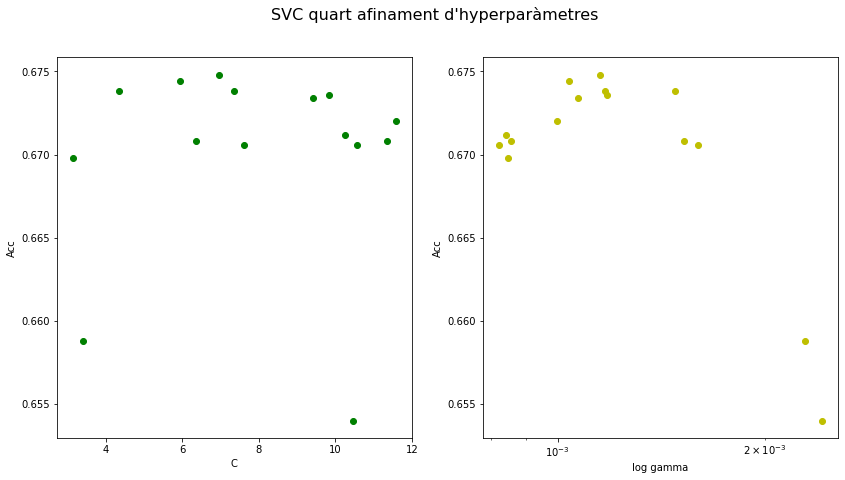

In [91]:
plt.figure(figsize = (2 * 7, 1 * 7))
plt.subplot(1, 2, 1)
plt.plot(cvData["param_svc__C"], cvData["mean_test_score"], linestyle = "", marker = 'o', color = "g")
plt.xlabel("C")
plt.ylabel("Acc")
plt.subplot(1, 2, 2)
plt.plot(cvData["param_svc__gamma"], cvData["mean_test_score"], linestyle = "", marker = 'o', color = "y")
plt.xlabel("log gamma")
plt.ylabel("Acc")
plt.xscale("log")
fig = plt.gcf()
fig.suptitle("SVC quart afinament d'hyperparàmetres", fontsize = 16)
plt.show()

## Millor model

In [83]:
print(rsCV_SVC.best_estimator_)
print(rsCV_SVC.best_score_)
# rsCV_SVC.best_estimator_.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=6.960189903709831, gamma=0.0011532078895434917))])
0.674800334050837


In [85]:
SVC_model = make_pipeline(StandardScaler(), 
                       SVC(kernel = 'rbf', gamma = 0.00115, C = 7, max_iter = 500))
SVC_model.fit(flatten(X_train), y_train)

d:\Estudi\Uni\Actual\TFG\Github\.venv\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=7, gamma=0.00115, max_iter=500))])

In [86]:
y_predict = SVC_model.predict(flatten(X_val))
accuracy_score(y_val, y_predict)

0.7995567375886525

In [89]:
y_predict_train = SVC_model.predict(flatten(X_train[-10000:]))
accuracy_score(y_train[-10000:], y_predict_train)

0.8941

In [90]:
# Reducció de C per veure si es generalitza millor
SVC_model2 = make_pipeline(StandardScaler(), 
                       SVC(kernel = 'rbf', gamma = 0.00115, C = 3, max_iter = 500))
SVC_model2.fit(flatten(X_train), y_train)

y_predict = SVC_model2.predict(flatten(X_val))
y_predict_train = SVC_model2.predict(flatten(X_train[-10000:]))
print(accuracy_score(y_val, y_predict))
print(accuracy_score(y_train[-10000:], y_predict_train))

d:\Estudi\Uni\Actual\TFG\Github\.venv\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


0.8020390070921986
0.8791


In [96]:
import joblib
# save models

joblib.dump(SVC_model, "models/svc_model1.joblib")
joblib.dump(SVC_model2, "models/svc_model2.joblib")
joblib.dump(rsCV_SVC, "models/randomSearch_SVC.joblib")

['models/randomSearch_SVC.joblib']

# Random Forest C

Hyperparàmetres possibles dels arbres a estimar:
- *n_estimators: nombre de trees en forest 
- *max_features: nombre de variables a considerar per la millor partició
- max_depth: nombre màxim de nivells per cada arbre
- min_samples_split: nombre minim de dades en un node abans de fer partició
- min_samples_leaf: nombre mínim de dades en un node (fulla)
- bootstrap: replacement o no.

1. param_dist = {'n_estimators': randint(100, 1000 + 1),
              'max_depth': list(np.append(None, np.linspace(start = 10, stop = 100, num = 5).astype(int))),
              'min_samples_split': randint(2, 10 + 1),
              'min_samples_leaf': randint(1, 4 + 1),
              'bootstrap': [True, False]} # n = 5000, n_iter = 100, t = 1,480s

2. param_dist = {'n_estimators': randint(200, 1500 + 1),
              'max_depth': list(np.append(None, np.linspace(start = 50, stop = 100, num = 5).astype(int))),
              'min_samples_split': randint(2, 5 + 1),
              'min_samples_leaf': randint(1, 2 + 1),
              'bootstrap': [False]} # n = 7000, n_iter = 75, t = 2,965s

3. param_dist = {'n_estimators': randint(1400, 2000 + 1),
              'max_depth': list(np.linspace(start = 50, stop = 100, num = 6).astype(int)),
              'min_samples_split': randint(2, 3 + 1)} # n = 8000, n_iter = 50, t = 17,500

In [301]:
from sklearn.ensemble import RandomForestClassifier

X_train_red, y_train_red = flatten(X_train[12000:20000]), y_train[12000:20000] # agafem mostres diferents per cada tanda

param_dist = {'n_estimators': randint(1400, 2000 + 1),
              'max_depth': list(np.linspace(start = 50, stop = 100, num = 6).astype(int)),
              'min_samples_split': randint(2, 3 + 1)}      
rf = RandomForestClassifier(bootstrap = False, min_samples_leaf = 1)

rsCV_RF = RandomizedSearchCV(rf, param_dist, n_iter = 50, verbose = 1, cv = 3)
rsCV_RF.fit(X_train_red, y_train_red)
cvData = pd.DataFrame(rsCV_RF.cv_results_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [310]:
cvData[["mean_test_score", "param_max_depth", "param_min_samples_split", "param_n_estimators"]].sort_values(by = ["mean_test_score"], ascending = False).head()

,mean_test_score,param_max_depth,param_min_samples_split,param_n_estimators
10,0.725251,80,2,1704
45,0.725001,80,3,1944
49,0.724376,70,3,1810
31,0.724376,60,3,1518
29,0.724251,60,2,1657


In [304]:
def binarize_data(cvData, nom_var):
    for idx, num in enumerate(cvData[nom_var]):
        if num is None:
            cvData[nom_var][idx] = "None"
    new_data = []
    labels = pd.unique(cvData[nom_var])
    for clase in labels:
        new_data.append(cvData["mean_test_score"][cvData[nom_var] == clase])
    return new_data, labels
    
def plot_hyper_RF(cvData, title):
    plt.figure(figsize = (2 * 6, 2 * 6))

    plt.subplot(2, 2, 1)
    x, noms = binarize_data(cvData, "param_max_depth")
    plt.boxplot(x)
    plt.xlabel("max_depth")
    plt.ylabel("Acc")
    plt.xticks(np.arange(len(x)) + 1, noms)

    plt.subplot(2, 2, 2)
    x, noms = binarize_data(cvData, "param_min_samples_split")
    idx = np.argsort(noms)
    plt.boxplot([x[i] for i in idx])
    plt.xlabel("min_samples_split")
    plt.ylabel("Acc")
    plt.xticks(np.arange(len(x)) + 1, noms[idx])

    plt.subplot(2, 2, 4)
    plt.plot(cvData["param_n_estimators"], cvData["mean_test_score"], linestyle = "", marker = 'o', color = "y")
    plt.xlabel("n_estimators")
    plt.ylabel("Acc")

    fig = plt.gcf()
    fig.suptitle(title, fontsize = 18)
    plt.show()

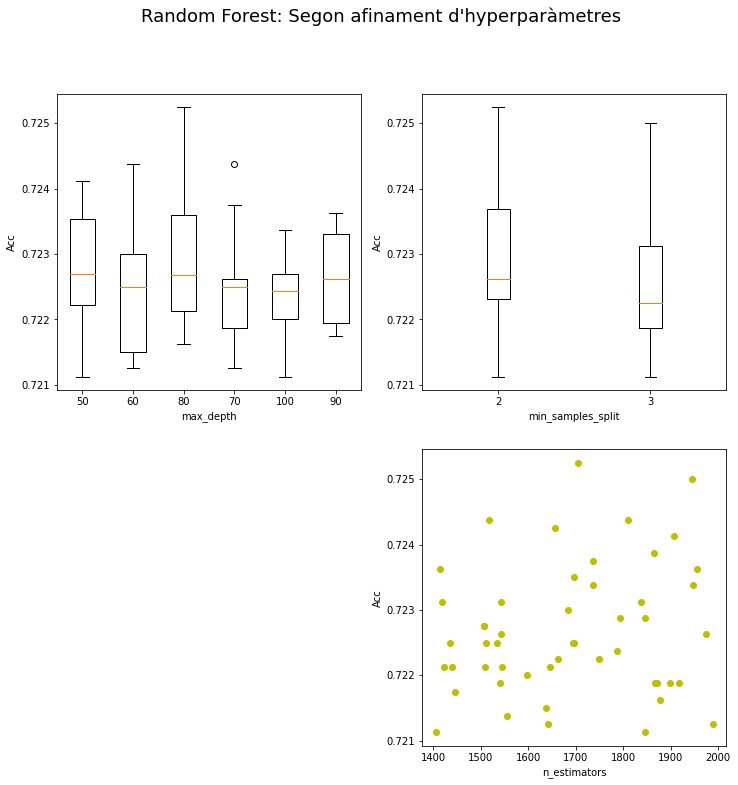

In [305]:
plot_hyper_RF(cvData, title = "Random Forest: Segon afinament d'hyperparàmetres")

In [307]:
rsCV_RF.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=80, n_estimators=1704)

## Millor model

In [309]:
print(rsCV_RF.best_estimator_)
print(rsCV_RF.best_score_)
# rsCV_RF.best_estimator_.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=80, n_estimators=1704)
0.7252511478075743


In [3]:
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier(n_estimators = 1000, max_depth = 80, bootstrap = False, min_samples_leaf = 1, min_samples_split = 2, random_state = 123) # Reduir n_estimators (era 1700), massa gran problemes per guardar el, model, no cap memoria ram, i probar bootstrap = True per regularitzar?
RF_model.fit(flatten(X_train), y_train)

RandomForestClassifier(bootstrap=False, max_depth=80, n_estimators=1000,
                       random_state=123)

In [4]:
print(RF_model.score(flatten(X_train)[:40000], y_train[:40000]))
print(RF_model.score(flatten(X_val), y_val))

1.0
0.8320035460992907


In [7]:
# Model null:
RF_model2 = RandomForestClassifier(random_state = 123)
RF_model2.fit(flatten(X_train)[:80000], y_train[:80000]) # s'ha reduït la mostra degut a insuficient memòria
print(RF_model2.score(flatten(X_val), y_val))

0.8081560283687943


In [5]:
import joblib
# save models

joblib.dump(RF_model, "models/RF_model1.joblib")

['models/RF_model1.joblib']

# Neural Network

In [4]:
import tensorflow as tf
from tensorflow import keras


In [99]:
keras.backend.clear_session()
np.random.seed(123)
tf.random.set_seed(123)

In [101]:
k = len(np.unique(y_train))
nn_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(400, activation = "relu"),
    keras.layers.Dense(200, activation = "relu"),
    keras.layers.Dense(100, activation = "relu"),
    keras.layers.Dense(k, activation = "softmax")
])
nn_model.compile(loss = "sparse_categorical_crossentropy", # keras.losses.sparse_categorical_crossentropy
              optimizer = keras.optimizers.SGD(learning_rate = 0.1), # buscat a sota,
              metrics = ["accuracy"])

checkpoint_cb = keras.callbacks.ModelCheckpoint("nn_logs/MLP_model1.h5", save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 20, restore_best_weights = True)

In [102]:
history = nn_model.fit(X_train / 255, y_train, epochs = 200, 
                       validation_data = (X_val / 255, y_val),
                       callbacks = [checkpoint_cb, early_stopping_cb]) # load: model = keras.models.load_model("nn_testing.h5")

Epoch 1/200
3173/3173 [==============================] - 8s 3ms/step - loss: 0.9985 - accuracy: 0.6946 - val_loss: 0.6344 - val_accuracy: 0.7855
Epoch 2/200
3173/3173 [==============================] - 7s 2ms/step - loss: 0.5649 - accuracy: 0.8095 - val_loss: 0.5461 - val_accuracy: 0.8194
Epoch 3/200
3173/3173 [==============================] - 7s 2ms/step - loss: 0.4741 - accuracy: 0.8350 - val_loss: 0.5088 - val_accuracy: 0.8283
Epoch 4/200
3173/3173 [==============================] - 8s 2ms/step - loss: 0.4207 - accuracy: 0.8502 - val_loss: 0.4909 - val_accuracy: 0.8364
Epoch 5/200
3173/3173 [==============================] - 7s 2ms/step - loss: 0.3824 - accuracy: 0.8618 - val_loss: 0.4807 - val_accuracy: 0.8379
Epoch 6/200
3173/3173 [==============================] - 7s 2ms/step - loss: 0.3525 - accuracy: 0.8697 - val_loss: 0.4934 - val_accuracy: 0.8326
Epoch 7/200
3173/3173 [==============================] - 7s 2ms/step - loss: 0.3278 - accuracy: 0.8775 - val_loss: 0.4708 - val_ac

In [104]:
best_model = keras.models.load_model("nn_logs/MLP_model1.h5")
print("training: ", best_model.evaluate(X_train / 255, y_train))
print("Valid: ", best_model.evaluate(X_val / 255, y_val))

3173/3173 [==============================] - 5s 1ms/step - loss: 0.2895 - accuracy: 0.8901
training:  [0.28951796889305115, 0.8901103138923645]
353/353 [==============================] - 1s 1ms/step - loss: 0.4708 - accuracy: 0.8485
Valid:  [0.4707845449447632, 0.8484929203987122]


In [105]:
best_model.save("models/nn_model.h5")

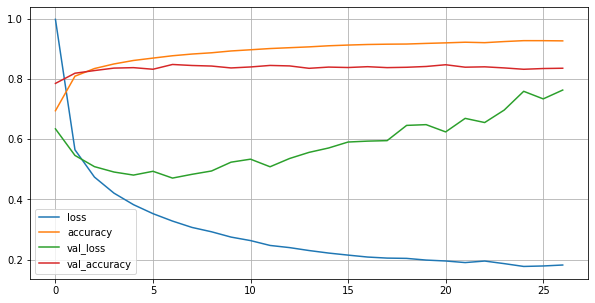

In [106]:
pd.DataFrame(history.history).plot(figsize = (10, 5))
plt.grid(True)
plt.show()

## Check LR

In [92]:
keras.backend.clear_session()
np.random.seed(123)
tf.random.set_seed(123)

In [93]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [94]:
k = len(np.unique(y_train))
nn_model_lr = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(400, activation = "relu"),
    keras.layers.Dense(200, activation = "relu"),
    keras.layers.Dense(100, activation = "relu"),
    keras.layers.Dense(k, activation = "softmax")
])
nn_model_lr.compile(loss = "sparse_categorical_crossentropy", # keras.losses.sparse_categorical_crossentropy
              optimizer = keras.optimizers.SGD(learning_rate = 1e-3),
              metrics = ["accuracy"])
expon_lr = ExponentialLearningRate(factor = 1.003)
history_lr = nn_model_lr.fit(X_train / 255, y_train, epochs = 1,
                       validation_data = (X_val / 255, y_val),
                       callbacks = [expon_lr])

3173/3173 [==============================] - 9s 3ms/step - loss: nan - accuracy: 0.2429 - val_loss: nan - val_accuracy: 0.0220


In [128]:
nn_model_lr = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [25, 2]),
     keras.layers.Dense(30, activation = "relu"),
    keras.layers.Dense(30, activation = "softmax")
])
nn_model_lr.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_7 (Dense)              (None, 30)                930       
Total params: 2,460
Trainable params: 2,460
Non-trainable params: 0
_________________________________________________________________


0.90311015


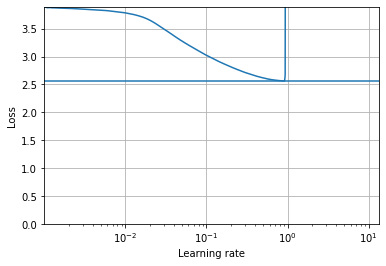

In [97]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")
print(expon_lr.rates[np.nanargmin(expon_lr.losses)]) # 0.1 o 1 learning rate

# CNN

Probar la CNN proposada per MNIST en https://github.com/ageron/handson-ml2/blob/master/14_deep_computer_vision_with_cnns.ipynb


In [161]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [114]:
X_train_C = X_train[..., np.newaxis] / 255
X_val_C = X_val[..., np.newaxis] / 255
X_test_C = X_test[..., np.newaxis] / 255

In [119]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(47, activation="softmax")
])

checkpoint_cb = keras.callbacks.ModelCheckpoint("cnn_logs/CNN_model1.h5", save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train_C, y_train, epochs=30, validation_data=(X_val_C, y_val), callbacks = [early_stopping_cb, checkpoint_cb])
# model.evaluate(X_test_C, y_test)

Epoch 1/30
3173/3173 [==============================] - 224s 70ms/step - loss: 1.0455 - accuracy: 0.6818 - val_loss: 0.4583 - val_accuracy: 0.8378
Epoch 2/30
3173/3173 [==============================] - 221s 70ms/step - loss: 0.6364 - accuracy: 0.7928 - val_loss: 0.3941 - val_accuracy: 0.8629
Epoch 3/30
3173/3173 [==============================] - 220s 69ms/step - loss: 0.5472 - accuracy: 0.8172 - val_loss: 0.3641 - val_accuracy: 0.8712
Epoch 4/30
3173/3173 [==============================] - 224s 71ms/step - loss: 0.5018 - accuracy: 0.8276 - val_loss: 0.3543 - val_accuracy: 0.8764
Epoch 5/30
3173/3173 [==============================] - 226s 71ms/step - loss: 0.4663 - accuracy: 0.8401 - val_loss: 0.3601 - val_accuracy: 0.8762
Epoch 6/30
3173/3173 [==============================] - 241s 76ms/step - loss: 0.4420 - accuracy: 0.8468 - val_loss: 0.3455 - val_accuracy: 0.8777
Epoch 7/30
3173/3173 [==============================] - 231s 73ms/step - loss: 0.4239 - accuracy: 0.8506 - val_loss: 0

In [124]:
best_model = keras.models.load_model("cnn_logs/CNN_model1.h5")
print("training: ", best_model.evaluate(X_train_C, y_train))
print("Valid: ", best_model.evaluate(X_val_C, y_val))

3173/3173 [==============================] - 28s 9ms/step - loss: 0.2322 - accuracy: 0.9106
training:  [0.2322240173816681, 0.9105890393257141]
353/353 [==============================] - 3s 9ms/step - loss: 0.3361 - accuracy: 0.8805
Valid:  [0.33608120679855347, 0.8804964423179626]


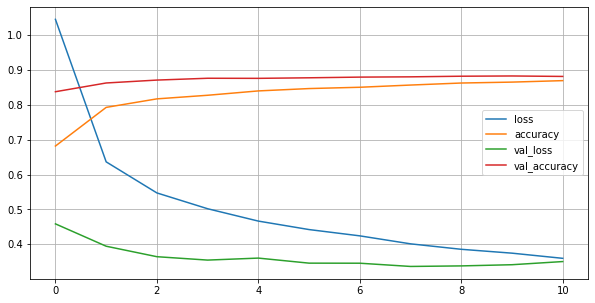

In [123]:
pd.DataFrame(history.history).plot(figsize = (10, 5))
plt.grid(True)
plt.show()

In [125]:
best_model.save("models/cnn_model.h5")

# Validació del model random forest, pesa massa per guardar-lo

In [10]:
RF_model.score(flatten(X_val), y_val)
RF_model.score(flatten(X_test), y_test)

0.8261702127659575

In [11]:
RF_model.score(flatten(X_val), y_val)

0.8320035460992907